In [2]:
%matplotlib inline

In [3]:
# %load source/estimate_impact.py
# Estimate the impact of using OddsCheck
import numpy as np
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing 
import sys
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.pipeline import Pipeline
from source.utils import ProjectsData
import warnings
warnings.filterwarnings('ignore')
import random
random.seed(55)

fname = 'data_csv/projects/projects.csv.ab'
# fname = 'data/opendata_projects000.gz'

projects = ProjectsData(fname)
projects.get_data()
# projects.sample(frac = .5)

# Unpickle the fitted pipeline and the model coefs
filename_model = 'models/pipe_logit_lasso_price.pkl'
pipe_price = pickle.load(open(filename_model, 'rb'))
filename_model = 'models/pipe_logit_lasso.pkl'
pipe = pickle.load(open(filename_model, 'rb'))

# Compute Optimal Price
from scipy import optimize
row = projects.df.iloc[[0]]
def expected_payoff(price, row, pipe):
    row.total_price_excluding_optional_support = price
    p_hat = pipe_price.predict_proba(row)[0][1]
    expected = p_hat * price
    return(-expected)

def est_prob(price, row, pipe):
    row.total_price_excluding_optional_support = price
    p_hat = pipe_price.predict_proba(row)[0][1]
    return(p_hat)


row = projects.df.iloc[[0]]
res = optimize.minimize_scalar(expected_payoff, args = (row, pipe), options = {'disp':False})
print(res.x)
price_opt = res.x

df = projects.df
df['p_hat'] = pipe.predict_proba(df)[:, 1]
df['price_oc'] = df.total_price_excluding_optional_support
df.price_oc[df.price_oc > price_opt] = price_opt

df_oc_price = df.copy()
df_oc_price['total_price_excluding_optional_support'] = df.price_oc
df['p_hat_oc'] = pipe.predict_proba(df_oc_price)[:, 1]

df['exp_payoff'] = df['total_price_excluding_optional_support'] * df['p_hat']
df['payoff'] = df['funded'] * df['total_price_excluding_optional_support']
df['exp_payoff_oc'] = df['price_oc'] * df['p_hat_oc']

total_payoff = df.payoff.sum()
total_exp_payoff = df.exp_payoff.sum()
total_exp_payoff_oc = df.exp_payoff_oc.sum()

print(total_payoff)
print(total_exp_payoff)
print(total_exp_payoff_oc)


removed the recent dates with incomplete projects
(10000, 44)
Initial size of data
(10000, 44)
Size of data after removing unnecessary columns apriori
(10000, 19)
The following columns have > 5% missing and are dropped
Index(['school_metro', 'secondary_focus_area'], dtype='object')
(10000, 17)
Removing outliers
(9998, 17)
Remove any rows with missing values
(9998, 17)
2078.84477348
3122169.019999976
2489644.208276543
2547519.686607888


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

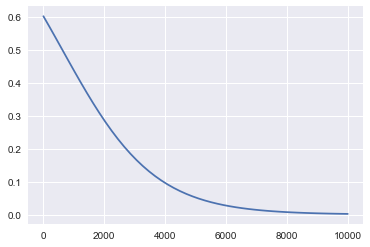

In [5]:
prices = np.linspace(1, 10001)
est_p = np.array(list(map(lambda x: est_prob(x, row, pipe), prices)))
plt.plot(prices, est_p)

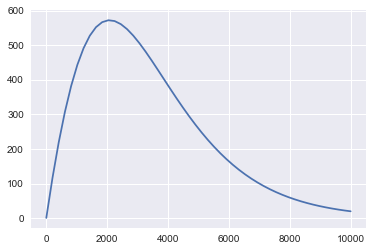

In [6]:
prices = np.linspace(1, 10001)
exp_payoffs = -np.array(list(map(lambda x: expected_payoff(x, row, pipe), prices)))
plt.plot(prices, exp_payoffs)

(array([  9.95100000e+03,   3.30000000e+01,   4.00000000e+00,
          1.00000000e+00,   3.00000000e+00,   4.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([     0.   ,   5639.243,  11278.486,  16917.729,  22556.972,
         28196.215,  33835.458,  39474.701,  45113.944,  50753.187,
         56392.43 ]),
 <a list of 10 Patch objects>)

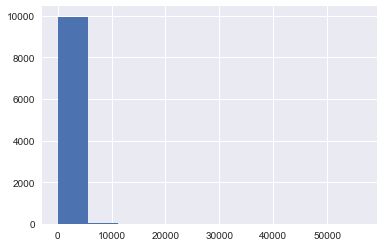

In [7]:
plt.hist(df.total_price_excluding_optional_support)



(array([  112.,    69.,   110.,   203.,   369.,   470.,   871.,  1936.,
         4022.,  1836.]),
 array([  9.91672149e-20,   6.58174693e-02,   1.31634939e-01,
          1.97452408e-01,   2.63269877e-01,   3.29087346e-01,
          3.94904816e-01,   4.60722285e-01,   5.26539754e-01,
          5.92357223e-01,   6.58174693e-01]),
 <a list of 10 Patch objects>)

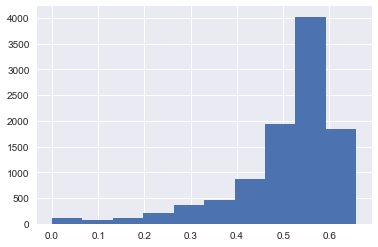

In [8]:
#df[df.total_price_excluding_optional_support > 5000]
p_hats = pipe.predict_proba(df)[:, 1]
plt.hist(p_hats)


In [9]:
df[df.total_price_excluding_optional_support > 5000]
#df[df.total_price_excluding_optional_support < 500]

,school_state,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_prefix,teacher_teach_for_america,teacher_ny_teaching_fellow,...,grade_level,total_price_excluding_optional_support,students_reached,funded,p_hat,price_oc,p_hat_oc,exp_payoff,payoff,exp_payoff_oc
90,NC,f,t,f,f,f,f,Ms.,f,f,...,Grades 3-5,8244.08,51.0,False,2.762032e-03,2078.844773,0.261132,2.277041e+01,0.00,542.852722
111,CA,t,f,f,f,f,f,Ms.,f,f,...,Grades 9-12,6469.80,150.0,False,1.147146e-02,2078.844773,0.268374,7.421808e+01,0.00,557.907564
277,CA,t,f,f,f,f,f,Mr.,f,f,...,Grades 9-12,7246.75,100.0,False,5.423691e-03,2078.844773,0.241036,3.930413e+01,0.00,501.077042
283,NC,f,f,f,f,f,f,Ms.,f,f,...,Grades 3-5,5228.52,30.0,False,2.505234e-02,2078.844773,0.234296,1.309867e+02,0.00,487.064641
493,NY,f,f,f,f,f,f,Ms.,f,f,...,Grades 9-12,5522.70,170.0,False,2.300725e-02,2078.844773,0.261132,1.270621e+02,0.00,542.852722
992,NY,f,f,f,f,f,f,Mr.,f,t,...,Grades 9-12,8411.15,60.0,False,2.098272e-03,2078.844773,0.234296,1.764888e+01,0.00,487.064641
1129,CA,f,f,f,f,f,f,Ms.,t,f,...,Grades 3-5,9515.08,1.0,True,9.150912e-04,2078.844773,0.241036,8.707166e+00,9515.08,501.077042
1788,CA,f,f,f,f,f,f,Mrs.,f,f,...,Grades 9-12,5625.20,5.0,False,1.541219e-02,2078.844773,0.202964,8.669666e+01,0.00,421.930371
2282,CA,f,f,f,f,f,f,Mrs.,f,f,...,Grades 3-5,6679.93,25.0,False,8.695709e-03,2078.844773,0.246483,5.808673e+01,0.00,512.399574
2944,CA,f,f,f,f,f,f,Mr.,f,f,...,Grades 6-8,10117.78,1200.0,False,5.124028e-04,2078.844773,0.222129,5.184378e+00,0.00,461.772079
